# DSM150-2022-OCT CW1
<i>student number: 210325986</i>

---------


In this notebook I will be building, training, and evaluating a neural network on the CIFAR100 dataset, consisting of 60000 labelled images. The task is a single-label, multi-class classification problem. Following the rubric of the coursework, I will build a neural network using just dense and dropout layers, and test whether it performs better when compared to a baseline model. 

The notebook is divided into seven sections, corresponding to the machine learning workflow outlined in Chollet (2018).

### **<u>Step 1</u>: Defining Problem and Assembling Dataset**

The CIFAR100 dataset, from the Canadian Institute for Advanced Research, is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are grouped into 100 classes ('fine' label), and these classes are in turn grouped into 20 superclasses ('coarse' label). 

For the purposes of this coursework, I will be using the coarse labels, meaning that the dataset consists of 60000 images divided into 20 classes.

The first step is to load the data and the required libraries.

In [1]:
#setting random seeds to ensure reproducable results
from numpy.random import seed
seed(10)
import tensorflow
tensorflow.random.set_seed(10)

In [2]:
#loading required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

In [3]:
#load data
data = cifar100.load_data(label_mode='coarse') #returns tuple of numpy arrays: (x_train, y_train), (x_test, y_test)

In [4]:
#dictionary of class labels (provided by dataset source)
labels_dict = ({0: 'aquatic_mammals', 1: 'fish', 2: 'flowers', 3: 'food_containers', 4: 'fruit_and_vegetables', 5: 'household_electrical_devices', 
                6: 'household_furniture', 7: 'insects', 8: 'large_carnivores', 9: 'large_man-made_outdoor_things', 10: 'large_natural_outdoor_scenes',
                11: 'large_omnivores_and_herbivores', 12: 'medium_mammals', 13: 'non-insect_invertebrates', 14: 'people', 15: 'reptiles', 
                16: 'small_mammals', 17: 'trees', 18: 'vehicles_1', 19: 'vehicles_2'} 
)

The dataset is divided into 50000 training samples and 10000 testing samples. Each sample is a 32x32 RGB colour image, thus giving 3 channels (the depth dimension). Images can only have one label, making this a single-label, multi-class classification problem.

In [5]:
(X_train, y_train), (X_test, y_test) = data

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Confirming (for the training set) that all classes contain the same amount of samples:

In [6]:
#printing counts per class
label_counts = dict(zip(*np.unique(y_train, return_counts=True)))
for key, value in label_counts.items():
      print(f'{key} ({labels_dict[key].upper()}):  {value}')

0 (AQUATIC_MAMMALS):  2500
1 (FISH):  2500
2 (FLOWERS):  2500
3 (FOOD_CONTAINERS):  2500
4 (FRUIT_AND_VEGETABLES):  2500
5 (HOUSEHOLD_ELECTRICAL_DEVICES):  2500
6 (HOUSEHOLD_FURNITURE):  2500
7 (INSECTS):  2500
8 (LARGE_CARNIVORES):  2500
9 (LARGE_MAN-MADE_OUTDOOR_THINGS):  2500
10 (LARGE_NATURAL_OUTDOOR_SCENES):  2500
11 (LARGE_OMNIVORES_AND_HERBIVORES):  2500
12 (MEDIUM_MAMMALS):  2500
13 (NON-INSECT_INVERTEBRATES):  2500
14 (PEOPLE):  2500
15 (REPTILES):  2500
16 (SMALL_MAMMALS):  2500
17 (TREES):  2500
18 (VEHICLES_1):  2500
19 (VEHICLES_2):  2500


### **<u>Step 2</u>: Defining a Measure of Success**

It has been shown that the number of samples for each class is equal. Hence, the dataset is balanced. In this situation, an appropriate measure of success for the classifier output is accuracy. 

The accuracy metric measures the number of correct predictions (true negatives and true positives) as a proportion of total predictions:

Accuracy = (TP + TN) / (TP + TN + FP + FN)

### **<u>Step 3</u>: Evaluation Protocol** 

Neural networks can be tuned through several non-trainable hyperparameters. One of the more important ones is the number of epochs; i.e. the number of times the entire training set is passed through the model. The optimal number of epochs is not known beforehand; this requires the model to be trained and evaluated on different values for this hyperparameter in order to find the value that maximises performance (based on the chosen performance metric, accuracy). However, the test set cannot be used for this procedure, as this would lead to overfitting when evaluating the final model. This necessitates the need for an additional evaluation protocol for tuning the number of epochs
(and possibly other hyperparameters). 

A common evaluation protocol for smaller datasets is k-fold cross validation. For each value of the hyperparameter being tuned, the training set will be split into k different folds, with the network trained on k-1 of the folds. The network performance will then be evaluated on the  remaining i'th fold, the validation set (i.e. the network's accuracy score on the validation set will be recorded). This process is repreated until all folds have been used once as the validation set. In this way, every training sample forms part of the validation set once, thereby reducing performance variation that can appear in small datasets. The final validation score will be the average accuracy accross all folds. This will be the performance of the network for the current value of the hyperparameter.

The process is then repreated for all values of the hyperparameter being evaluated. The optimal number of epochs is the one that achieves the best average performance across the k folds.

### **<u>Step 4</u>: Preparing the Data**

Data preparation (including feature extraction) is a critical step in the machine learning workflow, as the quality of the input data will greatly determine the network's performance.

In order to prepare the CIFAR100 dataset for input into the neural network, the following pre-processing steps have been identified:

1.   Vectorisation
2.   Tensor Re-shaping
3.   Scaling






The first step is to convert the categorical y labels into one-hot vectors, as machine learning models can only process numerical data:

In [7]:
#encoding categorical labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train[0] #check first observation

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

The second step is tensor reshaping. The X feature vector currently has the shape (n, 32, 32, 3), as images have three dimensions (width, height, shape), with n being the number of samples. However, dense networks, as will be used in this coursework, require 2D tensors as input. Hence, the input tensors will be re-shaped to (n, 32x32x3) = (n, 3072). 


In [8]:
#reshape features into 2D tensors
X_train = X_train.reshape((50000, 32*32*3)) 
X_test = X_test.reshape((10000, 32*32*3)) 

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (50000, 3072)
X_test shape: (10000, 3072)


The third step is scaling the data, since neural networks perform better when working with homogenous data (prevents large gradient updates). Networks also require the input data to be floating-point tensors.

Hence, the X features are converted from bytes to floats and scaled to between [0,1] by dividing by 255 (the maximum byte value).

In [9]:
#converting to float and scaling
X_train = X_train.astype('float32') / 255 
X_test = X_test.astype('float32') / 255 

### **<u>Step 5</u>: Choosing a Baseline**

A baseline model is a simple model that acts as a reference to contextualize the results of the trained network.

Since this is a single-label classification problem, a useful baseline model would be a random guesser. A random guesser assigns random class labels to each observation. The accuracy of such a model would be 1/c*100. Given that this problem contains c=20 classes, the accuracy of such a random guesser would be 5%. 

### **<u>Step 6</u>: Network Design**

The next step is to design a neural network that is hoped to outperform the baseline on the chosen performance metric. Network design broadly involves three steps:



1.   Topology - this refers to the way in which the network is connected. For the scope of this coursework, and in line with the rubric, the network will be sequential, formed of a stack of dense layers.
2.   Capacity - this refers to the number of trainable paramters in the model, and is mainly determined by the number of layers and the number of hidden units per layer. Since this is a relatively small dataset, a too large capacity will likely cause overfitting. For this reason, the network will consist of only two hidden layers, the first with 512 hidden units and the second with 256 hidden units. The hidden layers will both use a relu activation, which is preferable in dense layers to tanh or sigmoid. The final output layer will use a softmax activation, outputting a vector of 20 class probabilities.
3.   Compilation - this step will determine the learning process of the network. It involves the choice of optimiser and loss function. Since the loss function needs to be continouous and differentiable, the accuracy metric cannot be used as the loss function. Hence, the categorical cross-entropy will be used, common for multi-class, single-label classifications. The optimiser will be RMSprop, which is based on stochastic gradient descent. As explained above, the chosen performance metric will be the accuracy. 



In [10]:
#designing network
def neural_network_v1():
  '''
  Defining a dense network with two hidden layers and categorical cross entropy loss function.
  '''

  #network architecture 
  network = models.Sequential() 
  network.add(layers.Dense(512, activation='relu', input_shape=(3072, ))) 
  network.add(layers.Dense(256, activation='relu')) 
  network.add(layers.Dense(20, activation='softmax'))

  #compile network 
  network.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  return network

The first layer of the network will have (512x3027) weight parameters and 512 bias parameters, for a total of 1,573,376 trainable parameters. 

The hidden units in the second layer are connected to each of the first layer's units, thus giving (512x256) weight parameters and 256 bias parameters, for a total of 131,328 trainable parameters. Likewise, the final layer will have (256x20) weight parameters and 20 bias parameters, for a total of 5,140.

The total number of trainable parameters in the model is thus 1,709,844.



In [11]:
neural_network_v1().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 20)                5140      
                                                                 
Total params: 1,709,844
Trainable params: 1,709,844
Non-trainable params: 0
_________________________________________________________________


### **<u>Step 7</u>: Tuning & Optimisation**

The final step in the workflow is to tune the designed model and evaluate it against the baseline, optimising where possible.


##### **7.1 Validation & Tuning**

The below code implements the validation procedure for the designed network. The aim is to tune the 'epochs' hyperparameter. The code uses k=5 folds for the cross validation, and tests for up to 25 epochs.

In [12]:
#implementing k fold cross validation

#setting variables
k = 5 #number of folds
n_valid = len(X_train)//k #number of observations in validation set
valid_epochs = 25 #number of epochs to test in validation phase
training_metrics = []
valid_metrics = []

#iterating per fold
for i in range(k): #i from 0 to 4
    print('processing fold', i)
    
    #set aside validation partition for current fold
    lower_bound = i * n_valid
    upper_bound = (i + 1) * n_valid
    valid_features = X_train[lower_bound:upper_bound]
    valid_labels = y_train[lower_bound:upper_bound]
    
    #remaining data used for training in current fold
    train_features = np.concatenate([X_train[:lower_bound], X_train[upper_bound:]], axis=0)
    train_labels = np.concatenate([y_train[:lower_bound], y_train[upper_bound:]], axis=0)

    #build and train model
    valid_network = neural_network_v1()
    
    training = valid_network.fit(train_features, train_labels,
                        validation_data=(valid_features, valid_labels),
                        epochs=valid_epochs, batch_size=128, verbose=0)

    #storing scores using the 'history' object generated by the .fit() method
    training_metrics.append(training.history['loss'])
    valid_metrics.append(training.history['val_loss'])

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


The .history object returns a dictionary containing the training and validation metrics. For each of the k folds, each metric contains a list of the model performance across each of the 25 epochs. Choosing the optimal epoch can be done by visualising the training loss against the validation loss (how well the model performs on unseen data) - this can also be done by visualising the  training and validation accuracies.

In [13]:
print(f'History metrics: {list(training.history.keys())}')
print(f'Number of folds: {len(training_metrics)}')
print(f'Number of epochs: {len(training_metrics[0])}') #length of first fold scores list

History metrics: ['loss', 'accuracy', 'val_loss', 'val_accuracy']
Number of folds: 5
Number of epochs: 25


Viewing the validation results (after performing exponential smoothing):

In [14]:
#define exponential moving average smoothing function
def smooth_curve(points, factor = 0.75):
  '''
  Function to perform exponential smoothing on a list of values.
  '''
  smoothed_points = []
  for point in points:
      if smoothed_points: 
          previous = smoothed_points[-1] #use previous point to smooth current point
          smoothed_points.append(previous * factor + point * (1 - factor))
      else:
          smoothed_points.append(point)
  return smoothed_points

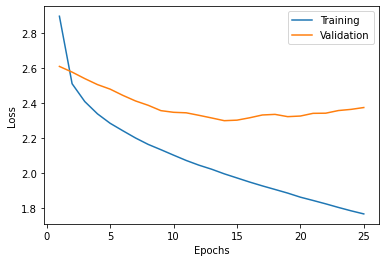

In [15]:
#plotting validation and training losses to identify optimal number of epochs

#average the loss for each epoch accross folds
mean_training_loss = [np.mean([x[i] for x in training_metrics]) for i in range(valid_epochs)]
mean_valid_loss = [np.mean([x[i] for x in valid_metrics]) for i in range(valid_epochs)]

#smoothen the validation loss
smooth_valid_loss = smooth_curve(mean_valid_loss)

#plotting
plt.plot(range(1, valid_epochs + 1), mean_training_loss, label = 'Training')
plt.plot(range(1, valid_epochs + 1), smooth_valid_loss, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


From the above chart, it is clear that while training loss falls as epochs increase, the validation loss falls rapidly at first but stalls at around 12 epochs. This is an indication that the network starts to overfit. Hence, the optimal number of epochs appears to be 12.

##### **7.2 Optimising & Evaluating**

Now that the optimal number of epochs has been identified, the network can be trained on the full training set and evaluated on the previously unseen test set:

In [16]:
opt_epochs = 12

#train on full training set using optimal number of epochs
full_network_v1 = neural_network_v1()
full_training_v1 = full_network_v1.fit(X_train, y_train, epochs=opt_epochs, batch_size=128, verbose=0)


The .evaluate() method provides the loss and accuracy metric for the tested network. As can be seen, the resulting accuracy is much higher than the 5% achieved by the baseline model, standing at 30%.

In [17]:
#evaluate on test set
full_network_v1.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.3094 - accuracy: 0.3041


[2.309396505355835, 0.30410000681877136]

There are several ways in which the network can be optimised further. Options include adding network capacity, regularisation, or dropout. For the purposes of this coursework, dropout layers will be added after each hidden layer, to test if network performance improves. Dropout randomly drops out a number of output features from a layer during training, which can help break up insignificant noise patterns in the data that might cause overfitting.


In [18]:
#define network with dropout layers
def neural_network_dropout(dr_rate):
  '''
  Defining a dense network with two hidden layers, two dropout layers, and categorical cross entropy loss function.
  '''

  #network architecture 
  network = models.Sequential() 
  network.add(layers.Dense(512, activation='relu', input_shape=(3072, ))) 
  network.add(layers.Dropout(dr_rate, seed = 10)) #seed to ensure randomisation is same with every code run
  network.add(layers.Dense(256, activation='relu')) 
  network.add(layers.Dropout(dr_rate, seed = 10))
  network.add(layers.Dense(20, activation='softmax'))

  #compile network 
  network.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  return network


In [19]:
#train and evaluate using optimal number of epochs for different dropout rates
dropout_scores = {}
dropout_vals = [0.25, 0.5, 0.75]
for d in dropout_vals:
  network_dr = neural_network_dropout(d)
  training_dr = network_dr.fit(X_train, y_train, epochs=opt_epochs, batch_size=128, verbose=0)
  acc = network_dr.evaluate(X_test, y_test)[-1] #returns list of loss, accuracy - only retain accuracy
  dropout_scores[d] = acc #save scores

313/313 [==============================] - 1s 3ms/step - loss: 2.9143 - accuracy: 0.0776


Evaluating on the unseen test set, it can be observed that adding the dropout layers does not lead to any improvement in the network's performance in this case. The best accuracy is 28% with a dropout value of 25% - higher dropout leads to worse performance. One reason could be that the dropout causes the network to lose vital information from the input data. Removing one of the dropout layers, could improve performance.

In [21]:
#viewing accuracy scores for different dropout rates
dropout_scores

{0.25: 0.2847999930381775, 0.5: 0.2011999934911728, 0.75: 0.07760000228881836}

### **<u>Concluding Remarks</u>**

In this coursework I attempted to fit and evaluate a neural network onto the CIFAR100 dataset. The task was a single-label, multi-class classification of images split into 20 different classes. In line with the coursework rubric, the neural network consisted of a sequential stack of two hidden dense layers and one output layer. k-fold cross validation was used to tune the network and select the optimal number of epochs. 

The results suggest that the network outperformed a random guesser, chosen as the baseline. An attempt to further improve the model using dropout layers was not successful.

Of course, this is just a simple exercise and many improvements could be made. Firstly, the task of image classification would generally require the use of convolutional layers, rather than dense layers. Secondly, attempts could be made to tune other hyperparameters of the model, such as the learning rate. Thirdly, there are several other options that could be used to further improve the network, such as tuning the dropout rate, regularisation, and increasing network capacity.


### **<u>References</u>**

#### **Websites**
https://www.cs.toronto.edu/~kriz/cifar.html

https://paperswithcode.com/dataset/cifar-100

https://towardsdatascience.com/ultimate-guide-to-input-shape-and-model-complexity-in-neural-networks-ae665c728f4b

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.py

#### **Other Material**
Chollet, F (2018). *Deep Learning with Python*. Manning Publications Co. ISBN 9781617294433

Neural Networks (DSM150-2022-OCT) - lectures & notebooks. University of London.